In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [3]:
# ========== 📥 LOAD DATA ==========
df = pd.read_csv(r"C:\Users\91636\Downloads\mainproject\projectt\uploads\train_test_network.csv")  # Path to your dataset

In [4]:
# ========== 📁 CREATE OUTPUT FOLDER IF NEEDED ==========
os.makedirs("models", exist_ok=True)

In [5]:
# ========== 🔍 BASIC CHECKS ==========
print("🔹 Shape of dataset:", df.shape)
print("🔹 Columns:", df.columns.tolist())
print("🔹 Missing values:\n", df.isnull().sum())

🔹 Shape of dataset: (2141, 8)
🔹 Columns: ['tcp.srcport', 'tcp.dstport', 'tcp.len', 'http.content_length', 'tcp.seq', 'tcp.ack', 'tcp.raw_ack', 'attack_type']
🔹 Missing values:
 tcp.srcport            0
tcp.dstport            0
tcp.len                0
http.content_length    0
tcp.seq                0
tcp.ack                0
tcp.raw_ack            0
attack_type            0
dtype: int64


In [6]:
# ========== 🧪 ATTACK TYPE DISTRIBUTION ==========
attack_counts = df["attack_type"].value_counts()
print("\n📊 Attack Type Distribution:\n", attack_counts)
attack_percent = (attack_counts / len(df) * 100).round(2).astype(str) + '%'
print("\n📊 Attack Type % Distribution:\n", attack_percent)


📊 Attack Type Distribution:
 attack_type
Normal           856
DDoS_TCP         429
Password         428
Port_Scanning    428
Name: count, dtype: int64

📊 Attack Type % Distribution:
 attack_type
Normal           39.98%
DDoS_TCP         20.04%
Password         19.99%
Port_Scanning    19.99%
Name: count, dtype: object


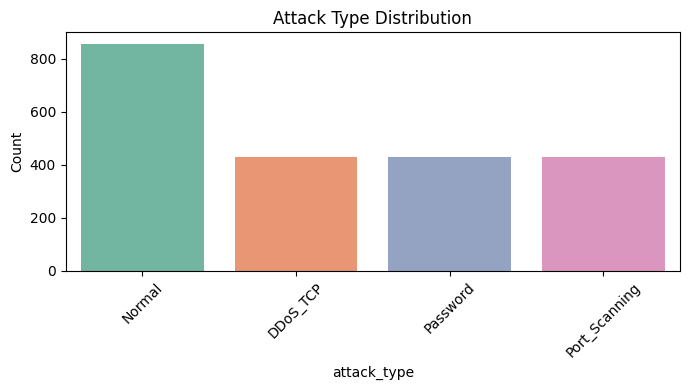

In [7]:
# Barplot of class distribution
plt.figure(figsize=(7, 4))
sns.barplot(x=attack_counts.index, y=attack_counts.values, palette='Set2')
plt.title("Attack Type Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("models/attack_type_distribution.png")
plt.show()

In [8]:
# ========== 🧪 DUPLICATE & CONSTANT VALUE CHECK ==========
print(f"\n📎 Duplicate Rows: {df.duplicated().sum()}")
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print(f"⚠️ Constant/Single-value columns: {constant_features}")


📎 Duplicate Rows: 2066
⚠️ Constant/Single-value columns: []


In [9]:
# ========== 🧪 FEATURE-TARGET CORRELATION ==========
le = LabelEncoder()
df['target_enc'] = le.fit_transform(df['attack_type'])
corr_with_target = df.drop(columns='attack_type').corr(numeric_only=True)['target_enc'].sort_values(ascending=False)
print("\n🔍 Correlation with Target:\n", corr_with_target.head(10))



🔍 Correlation with Target:
 target_enc             1.000000
tcp.dstport            0.774495
tcp.srcport           -0.058449
http.content_length   -0.197386
tcp.ack               -0.230272
tcp.len               -0.425185
tcp.raw_ack           -0.953122
tcp.seq               -0.988106
Name: target_enc, dtype: float64


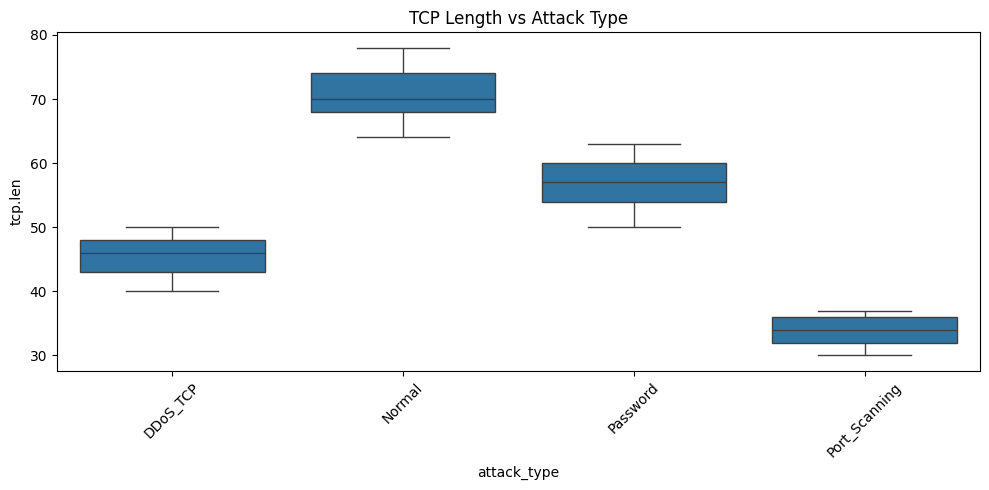

In [10]:
# ========== 📊 FEATURE DISTRIBUTION BY ATTACK TYPE ==========
if 'tcp.len' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='attack_type', y='tcp.len', data=df)
    plt.title("TCP Length vs Attack Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("models/boxplot_tcp_len_vs_attack_type.png")
    plt.show()



In [11]:
# ========== 🧹 DROP UNUSED ==========
df.drop(columns=['target_enc'], inplace=True)
if constant_features:
    df.drop(columns=constant_features, inplace=True)


In [ ]:
# ========== 🔀 SHUFFLE ==========
df = shuffle(df, random_state=42)

In [13]:
# ========== 🎯 FEATURE/TARGET SPLIT ==========
X = df.drop(columns=['attack_type'])
y = df['attack_type']

In [14]:
# ========== 🔄 TRAIN/TEST SPLIT ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [15]:
# ========== ⚖️ SCALING ==========
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

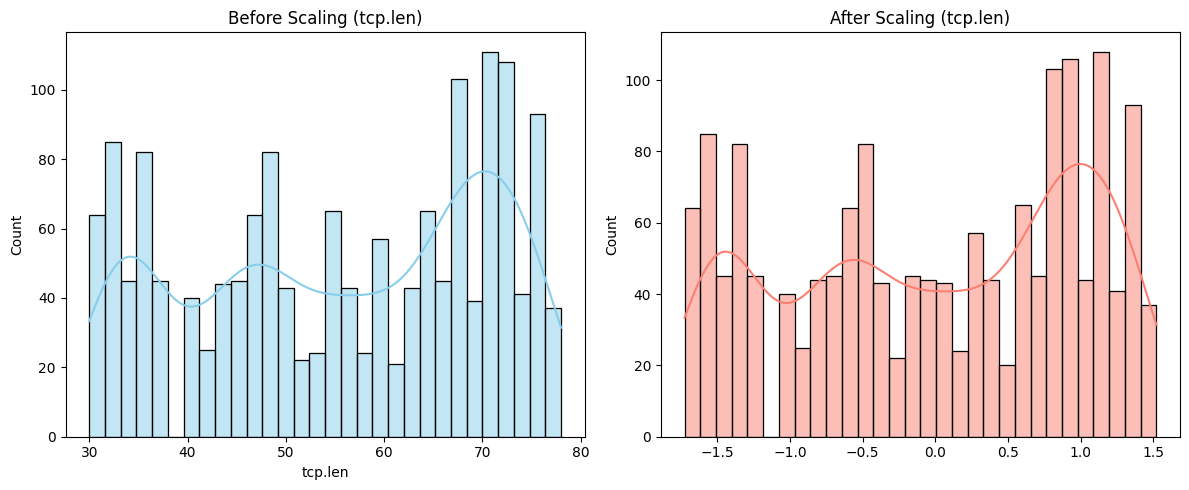

In [16]:
# ========== 📉 BEFORE/AFTER SCALING ==========
if 'tcp.len' in X.columns:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(X_train['tcp.len'], kde=True, bins=30, color='skyblue')
    plt.title("Before Scaling (tcp.len)")

    plt.subplot(1, 2, 2)
    sns.histplot(X_train_scaled[:, X.columns.get_loc('tcp.len')], kde=True, bins=30, color='salmon')
    plt.title("After Scaling (tcp.len)")

    plt.tight_layout()
    plt.savefig("models/scaling_comparison.png")
    plt.show()

In [17]:
# ========== 🧪 DUMMY BASELINE ==========
dummy = DummyClassifier(strategy='most_frequent').fit(X_train_scaled, y_train)
dummy_acc = accuracy_score(y_test, dummy.predict(X_test_scaled))
print(f"\n⚠️ Dummy Classifier Accuracy (Baseline): {dummy_acc*100:.2f}%")


⚠️ Dummy Classifier Accuracy (Baseline): 39.93%


In [18]:
# ========== ✅ MODEL TRAINING ==========
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [19]:
# ========== 📊 METRICS ==========
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))
print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"✅ Model Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")


✅ Classification Report:
                precision    recall  f1-score   support

     DDoS_TCP       1.00      1.00      1.00       108
       Normal       1.00      1.00      1.00       214
     Password       1.00      1.00      1.00       107
Port_Scanning       1.00      1.00      1.00       107

     accuracy                           1.00       536
    macro avg       1.00      1.00      1.00       536
 weighted avg       1.00      1.00      1.00       536

✅ Confusion Matrix:
 [[108   0   0   0]
 [  0 214   0   0]
 [  0   0 107   0]
 [  0   0   0 107]]
✅ Model Accuracy: 100.00%


In [20]:
# ========== 📊 FEATURE IMPORTANCE ==========
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

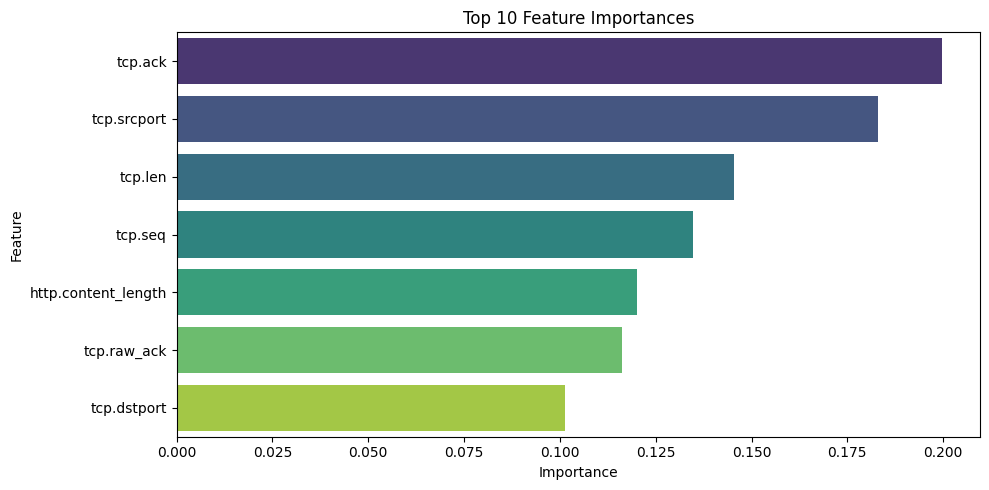

In [21]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.savefig("models/feature_importance.png")
plt.show()

In [23]:
import seaborn as sns
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, auc
)
from itertools import cycle
from IPython.display import display

In [24]:
plt.style.use("ggplot")
os.makedirs('models/graphs', exist_ok=True)

In [25]:
# 📥 Load Dataset
df = pd.read_csv('Train_Test_Network.csv')
df.columns = df.columns.str.strip().str.lower()

In [26]:
# 📋 Show first 10 rows
print("\n📋 Dataset Preview (first 10 rows):")
print(df.head(10).to_string(index=False))


📋 Dataset Preview (first 10 rows):
 tcp.srcport  tcp.dstport  tcp.len  http.content_length  tcp.seq  tcp.ack  tcp.raw_ack   attack_type
       52345           80       45                    0     1020      150         1020      DDoS_TCP
          80          443       68                  120      750     1800          900        Normal
        9001           22       55                   80      600     1100          700      Password
       20000        25000       30                    0      300       50          300 Port_Scanning
          80          443       72                  180      800     1900          950        Normal
       15000           80       40                    0      980      120          980      DDoS_TCP
          80          443       65                  110      720     1750          880        Normal
        9002           21       50                   70      580     1050          680      Password
       21000        26000       32                    0

In [27]:
# 📊 Show Attack Type Distribution
attack_counts = df['attack_type'].value_counts()
attack_percent = df['attack_type'].value_counts(normalize=True) * 100
print("\n📊 Attack Type Distribution (Count Table):")
print(attack_counts.to_string())
print("\n📊 Attack Type Distribution (Percentage):")
print((attack_percent.round(2).astype(str) + "%").to_string())


📊 Attack Type Distribution (Count Table):
attack_type
Normal           856
DDoS_TCP         429
Password         428
Port_Scanning    428

📊 Attack Type Distribution (Percentage):
attack_type
Normal           39.98%
DDoS_TCP         20.04%
Password         19.99%
Port_Scanning    19.99%


In [28]:
# Save attack distribution
attack_counts.to_csv("models/attack_type_counts.csv", header=["Count"])

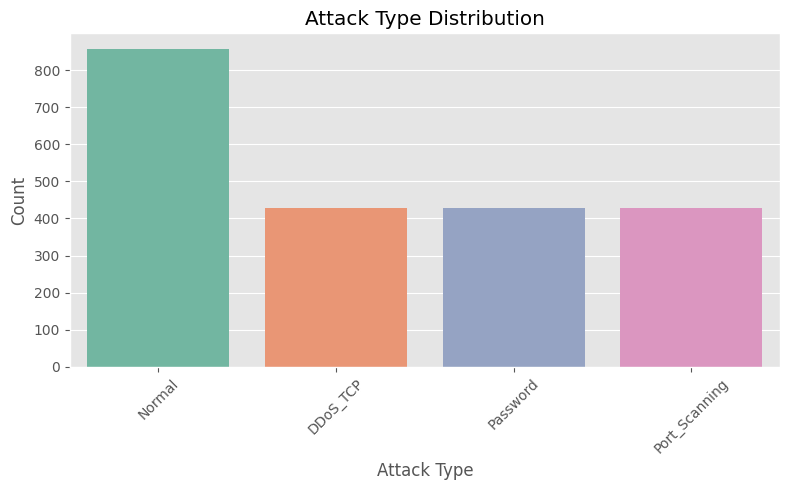

In [29]:
# 📊 Enhanced Distribution Barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=attack_counts.index, y=attack_counts.values,
            hue=attack_counts.index, palette="Set2",
            dodge=False, legend=False)
plt.title("Attack Type Distribution")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("models/graphs/attack_type_distribution.png")
plt.show()

In [30]:
# 🔍 Features and Labels
features = [
    'tcp.srcport', 'tcp.dstport', 'tcp.len',
    'http.content_length', 'tcp.seq', 'tcp.ack', 'tcp.raw_ack'
]
label_col = 'attack_type'
df = df[features + [label_col]].dropna()

X = df[features]
y = df[label_col]
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y)
n_classes = len(lb.classes_)

In [31]:
# 🧪 Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
_, _, y_train_bin, y_test_bin = train_test_split(
    X, y_binarized, test_size=0.2, random_state=42, stratify=y
)

In [36]:
# ⚖️ Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

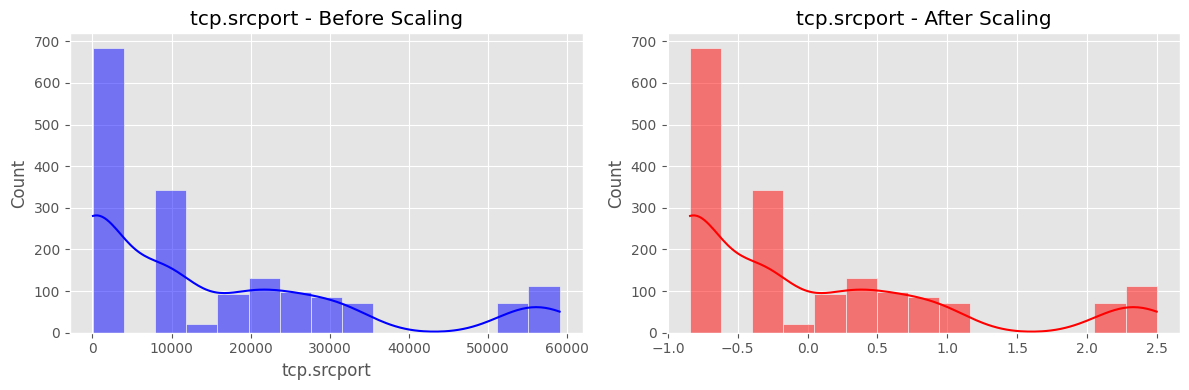

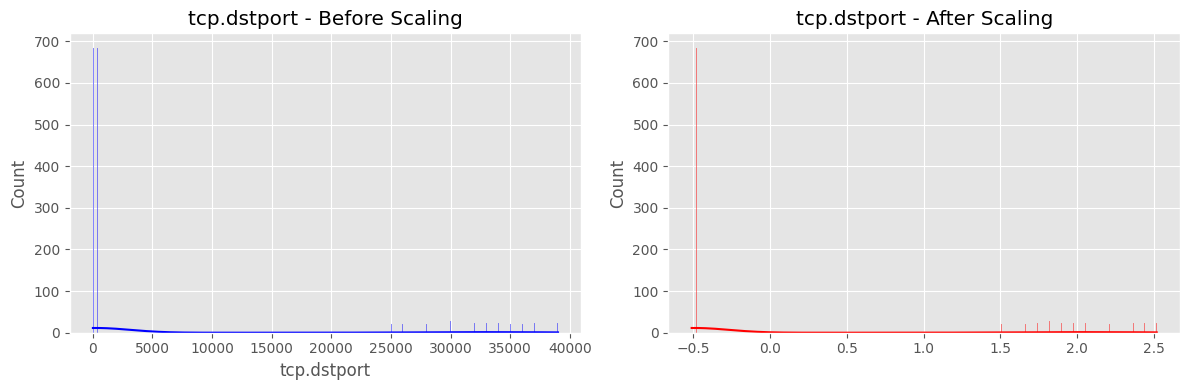

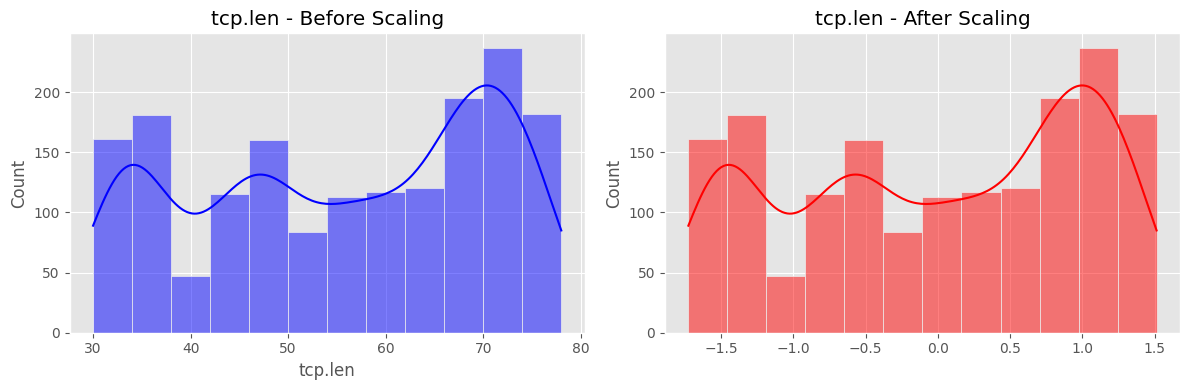

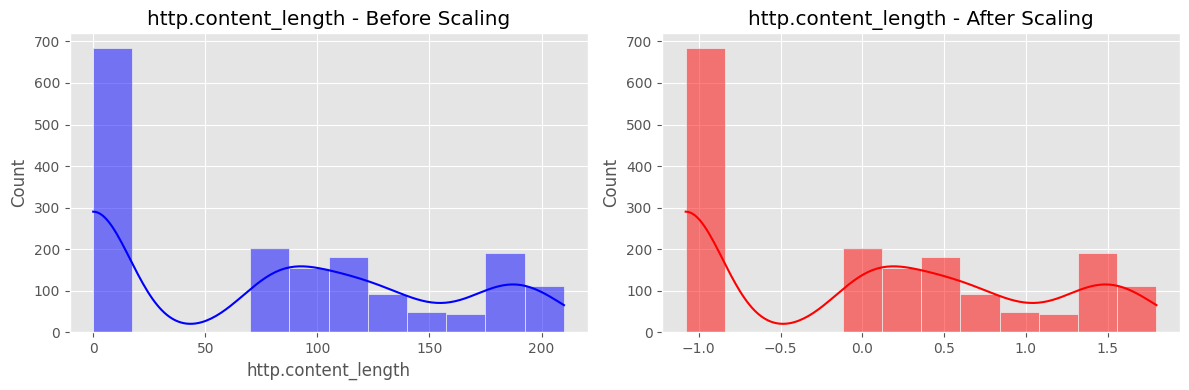

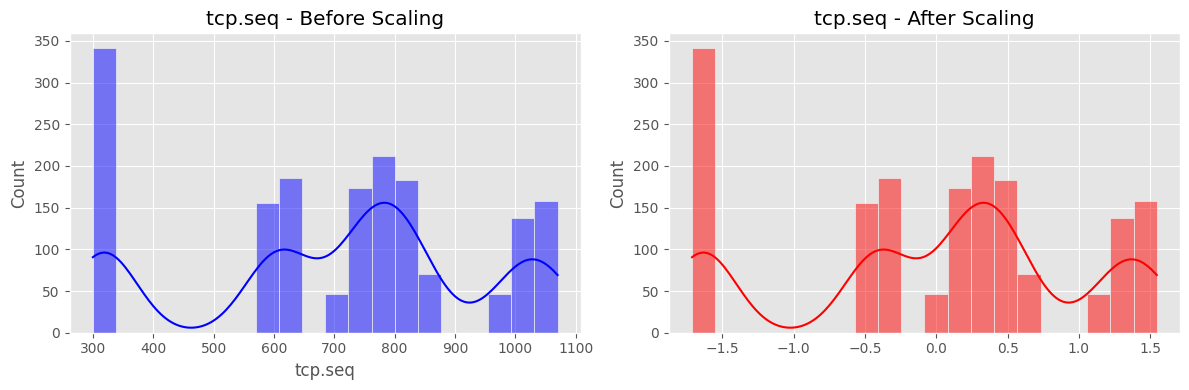

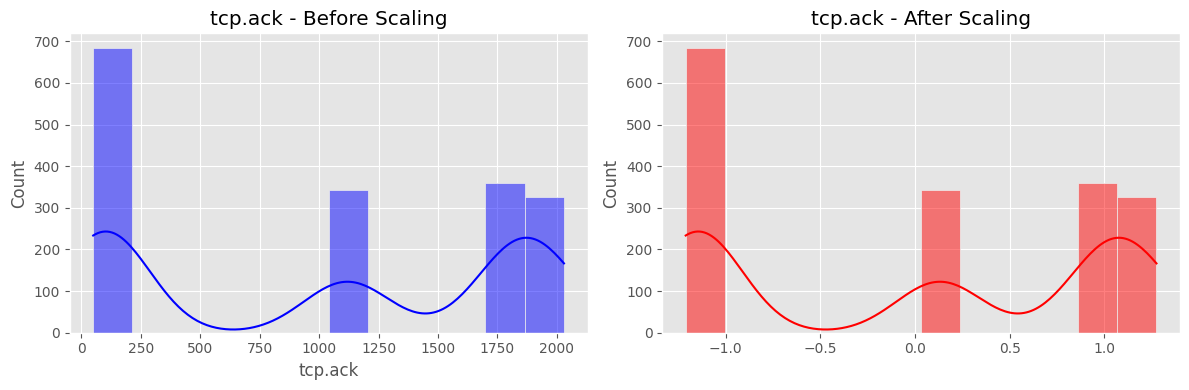

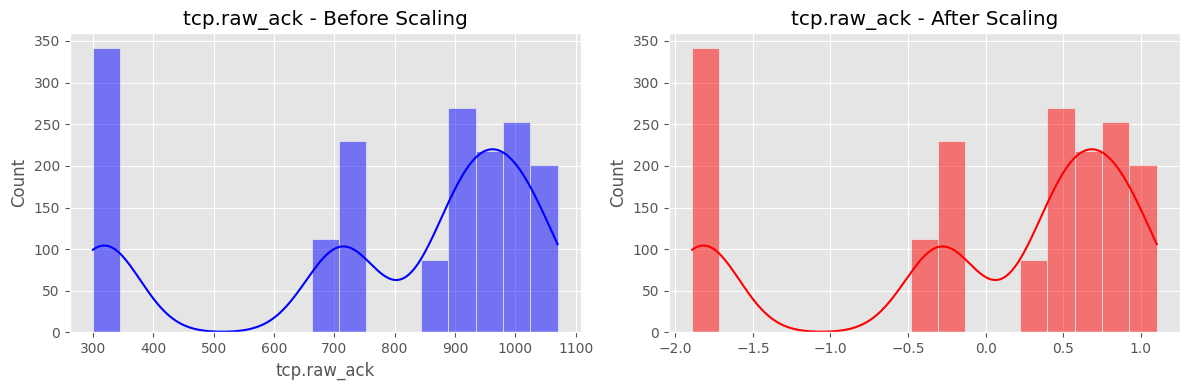

✅ Saved all feature distribution plots before and after scaling.


In [37]:
# 📉 Before and After Scaling Graphs
for feature in features:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(X_train[feature], kde=True, color='blue')
    plt.title(f'{feature} - Before Scaling')

    plt.subplot(1, 2, 2)
    index = features.index(feature)
    sns.histplot(X_train_scaled[:, index], kde=True, color='red')
    plt.title(f'{feature} - After Scaling')

    plt.tight_layout()
    plt.savefig(f"models/graphs/feature_{feature}_scaling.png")
    plt.show()
    plt.close()

print("✅ Saved all feature distribution plots before and after scaling.")

In [38]:
# 🚀 Define Models
models = {
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'decision_tree': DecisionTreeClassifier(random_state=42),
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'logistic_regression': LogisticRegression(max_iter=1000, random_state=42),
    'svm': SVC(probability=True, random_state=42),
    'k_neighbors': KNeighborsClassifier(n_neighbors=5),
    'extra_trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'mlp': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, activation='relu', solver='adam', random_state=42)
}
accuracy_scores = {}
summary_rows = []


🚀 Training Random_Forest...
✅ Accuracy: 100.00%


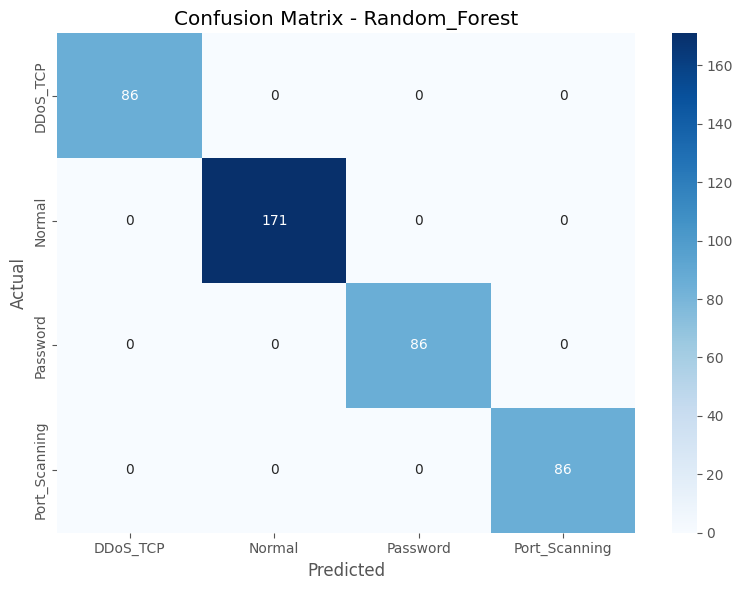

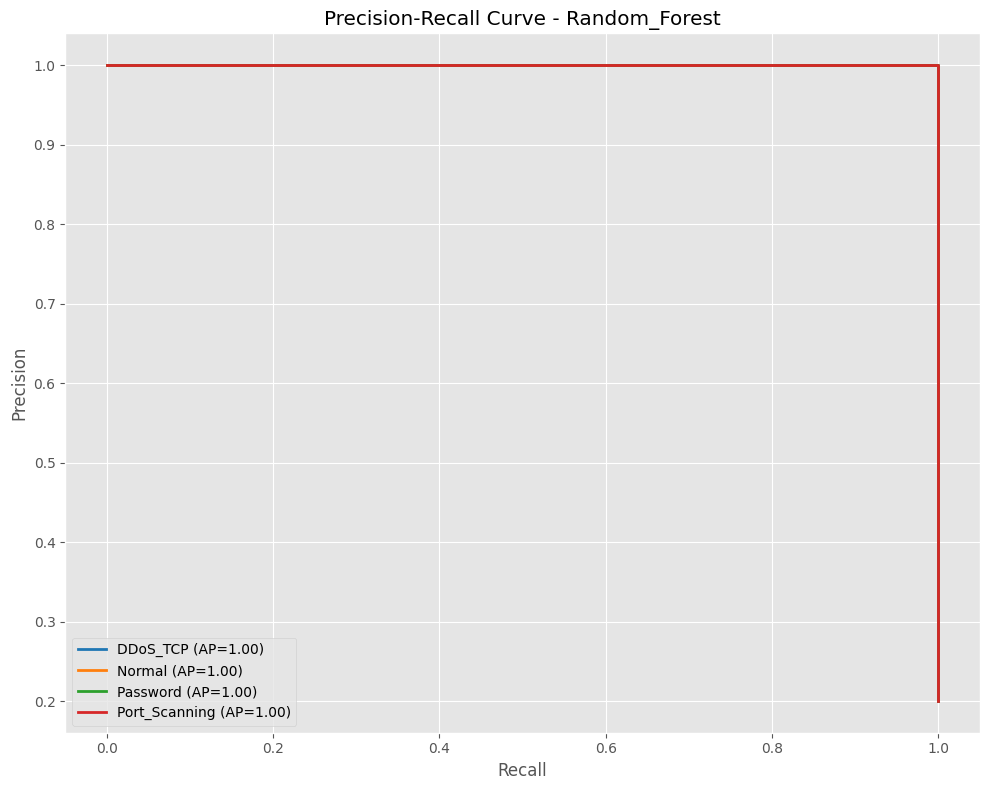


🚀 Training Decision_Tree...
✅ Accuracy: 100.00%


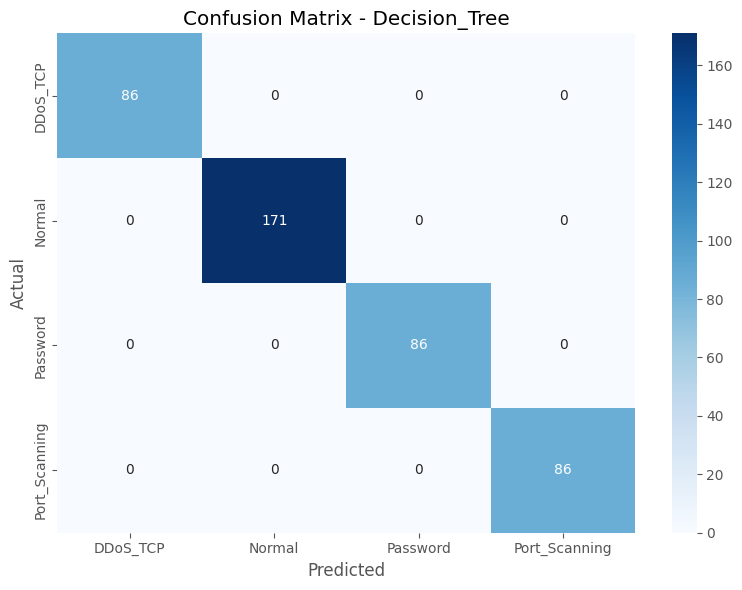

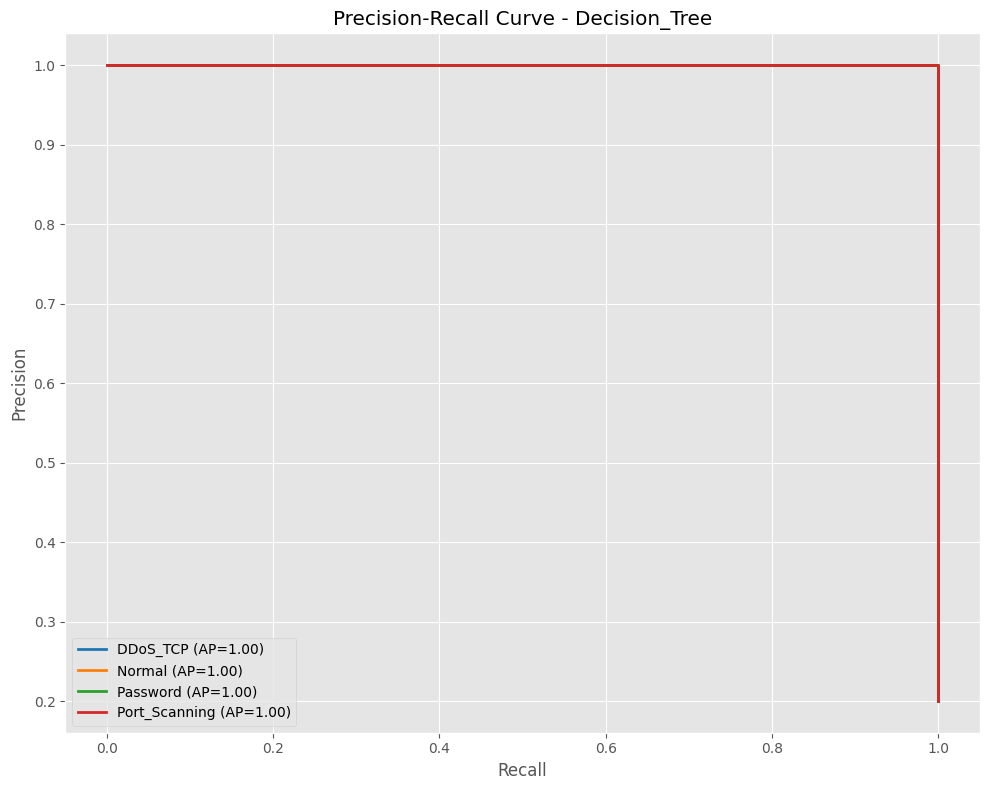


🚀 Training Gradient_Boosting...
✅ Accuracy: 100.00%


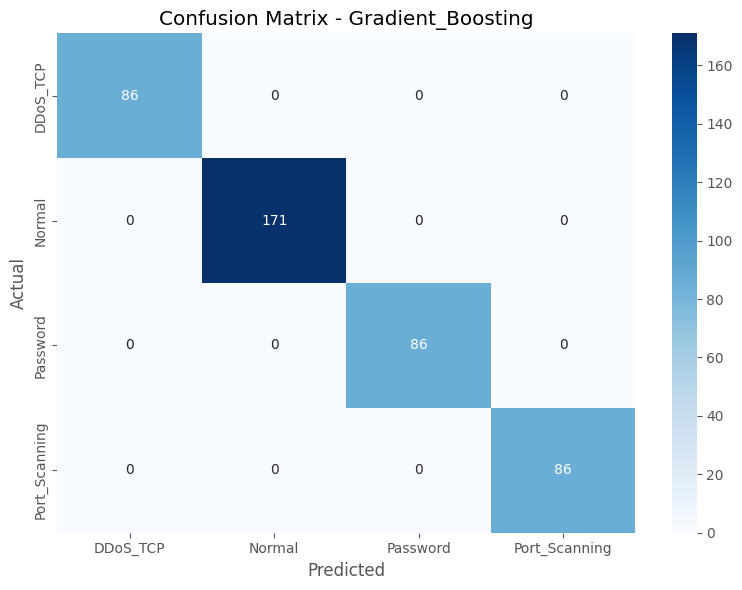

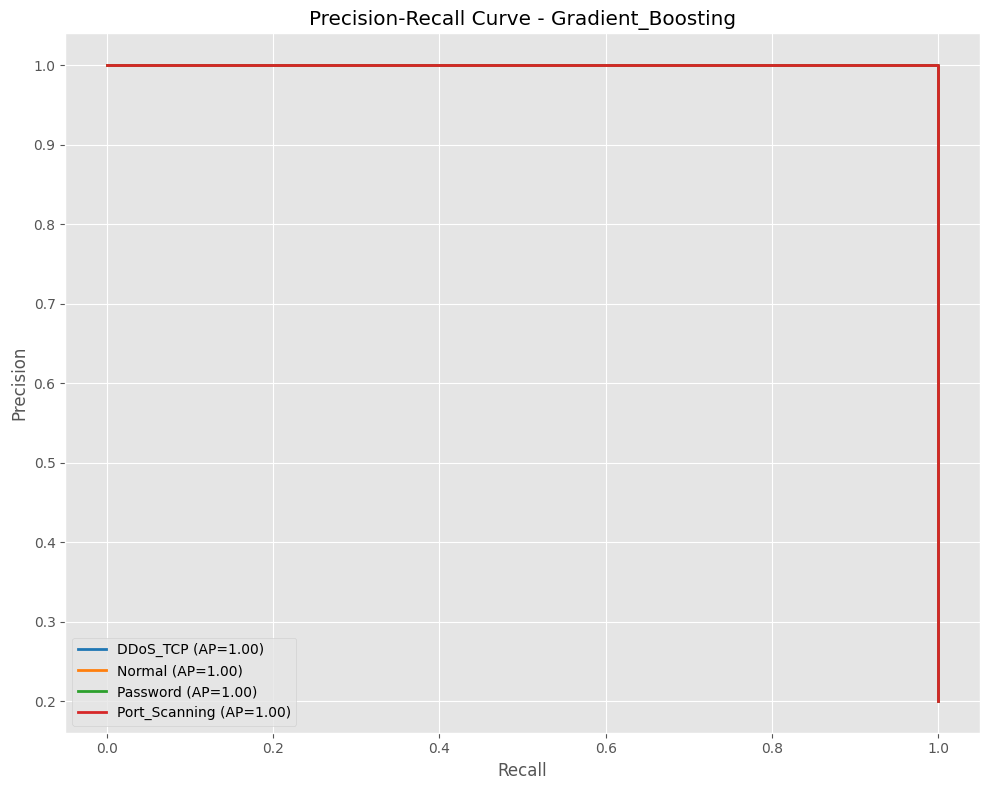


🚀 Training Logistic_Regression...
✅ Accuracy: 100.00%


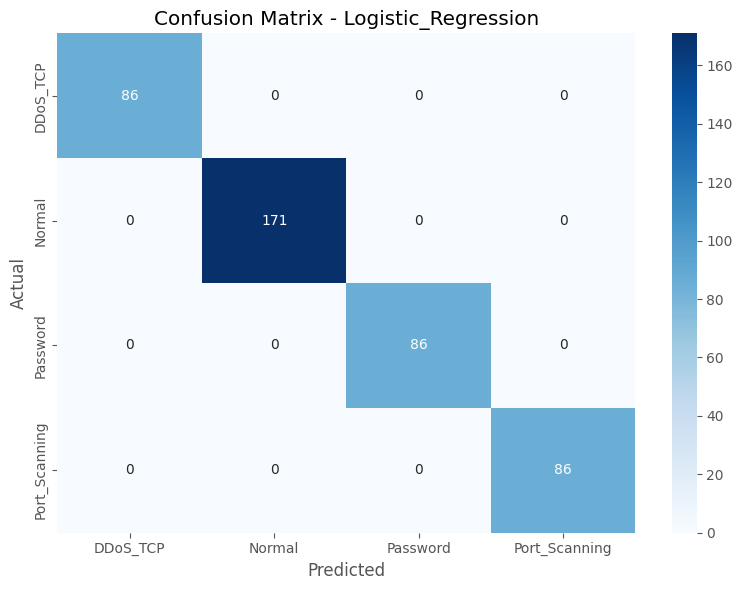

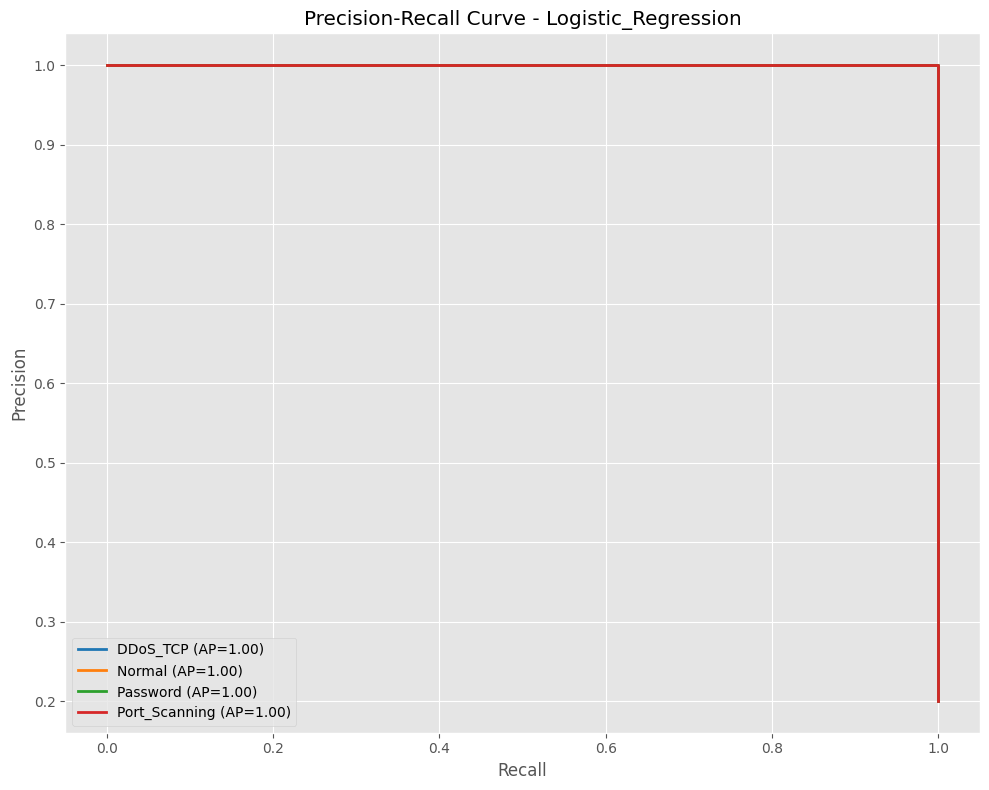


🚀 Training Svm...
✅ Accuracy: 100.00%


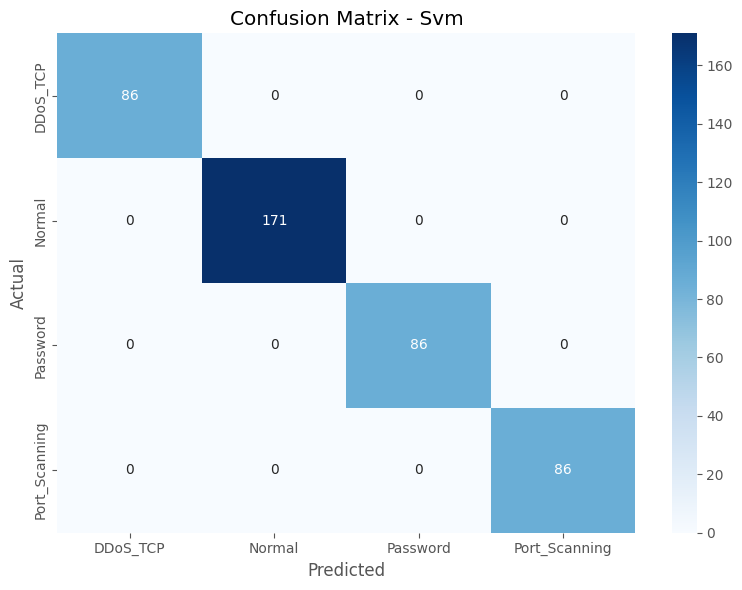

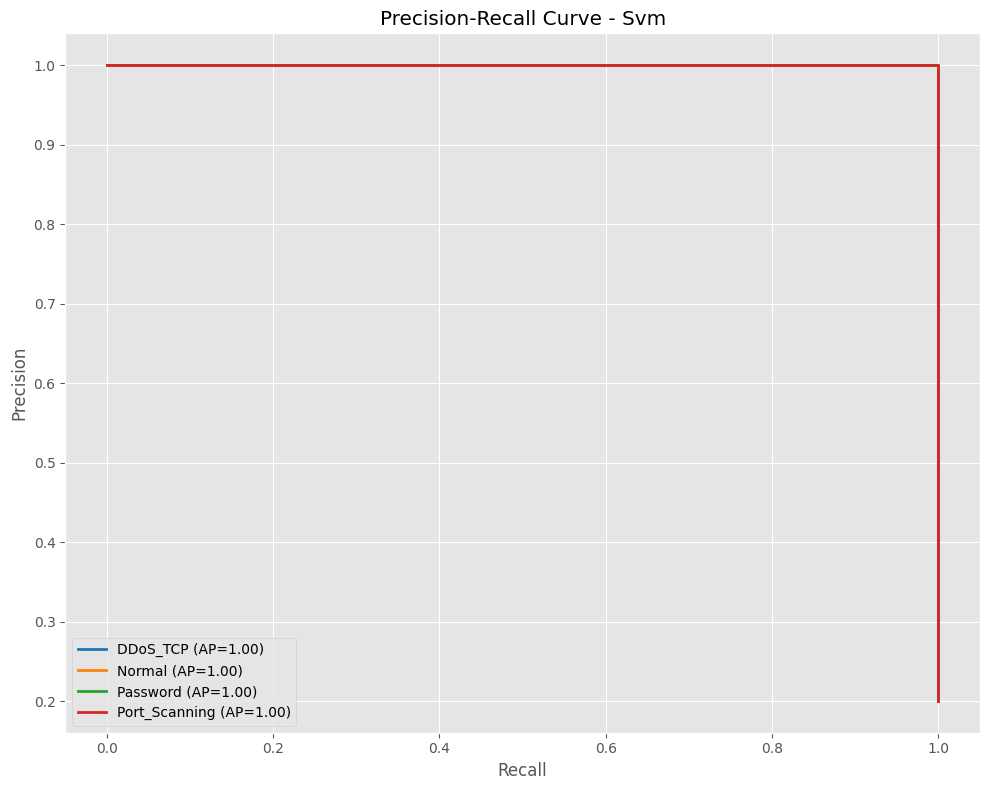


🚀 Training K_Neighbors...
✅ Accuracy: 100.00%


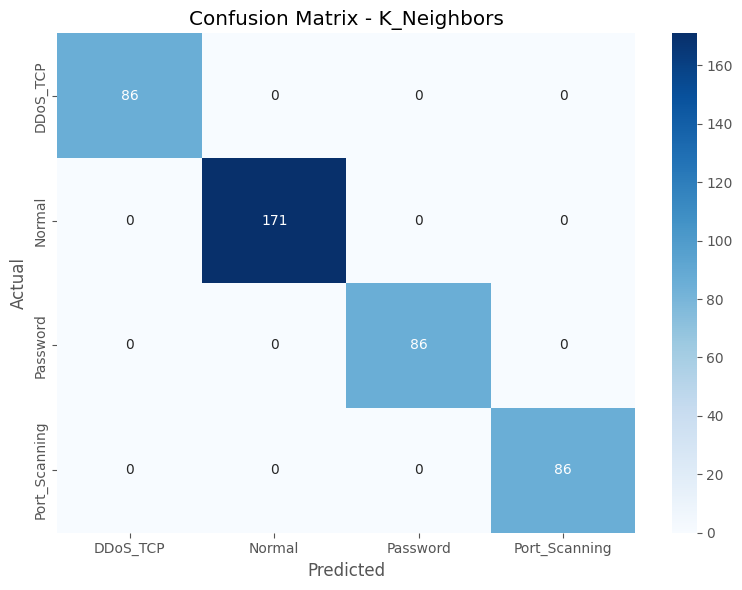

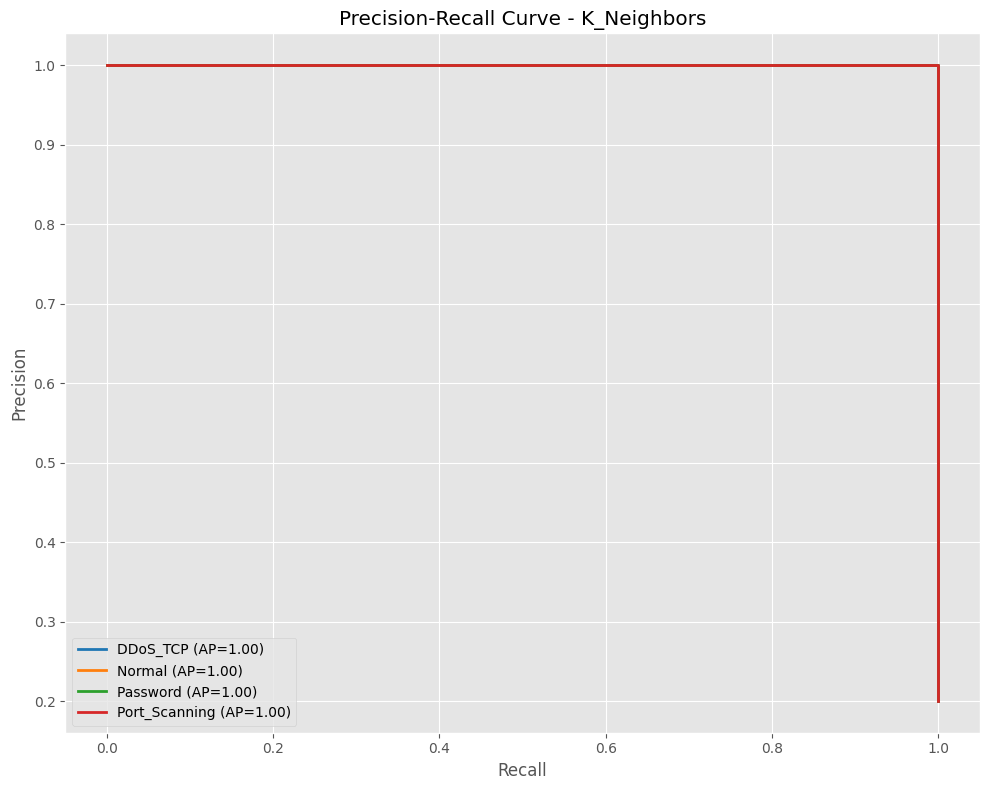


🚀 Training Extra_Trees...
✅ Accuracy: 100.00%


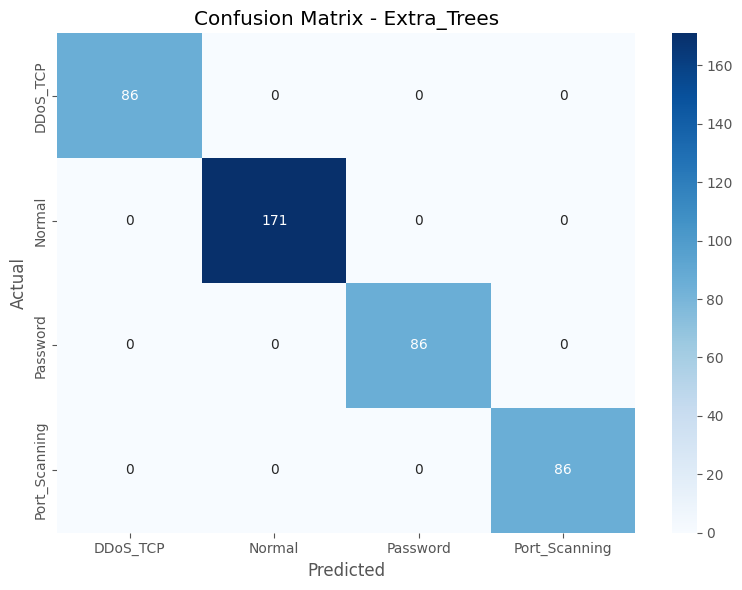

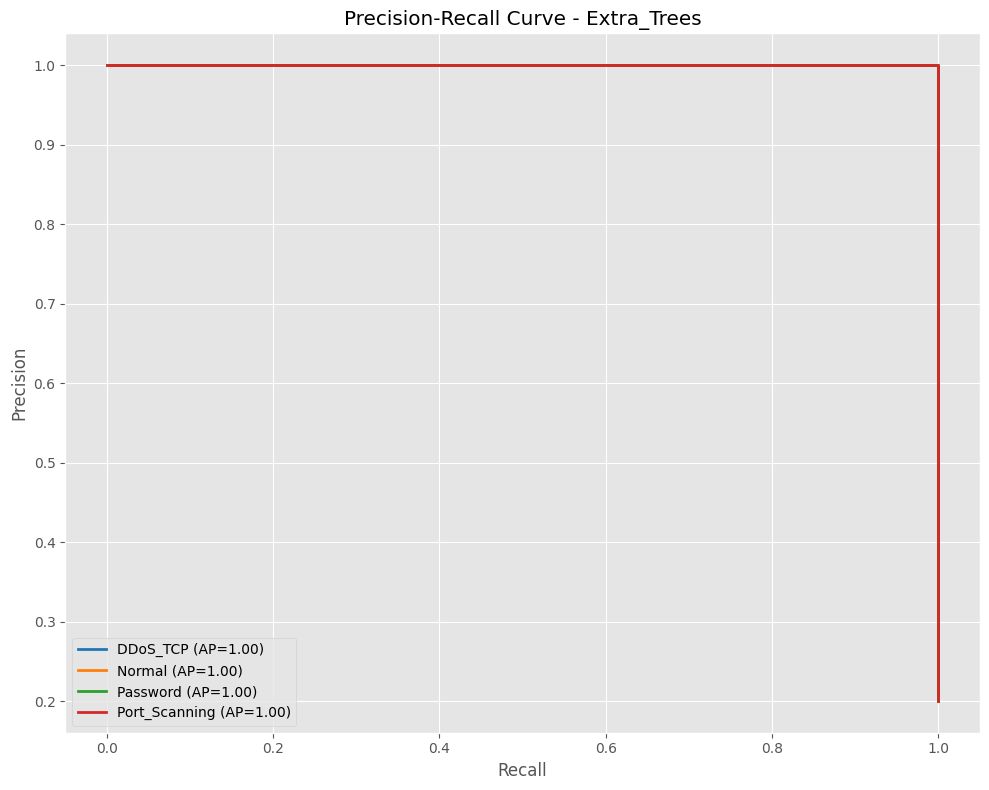


🚀 Training Mlp...
✅ Accuracy: 100.00%


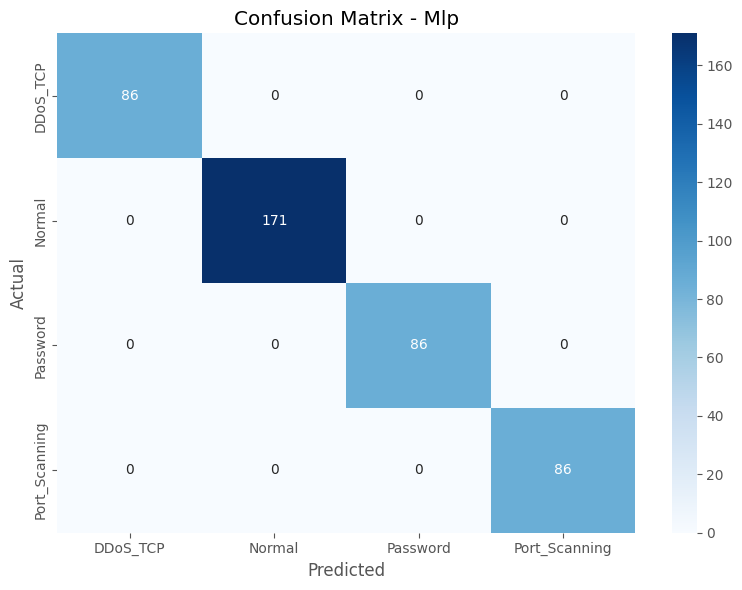

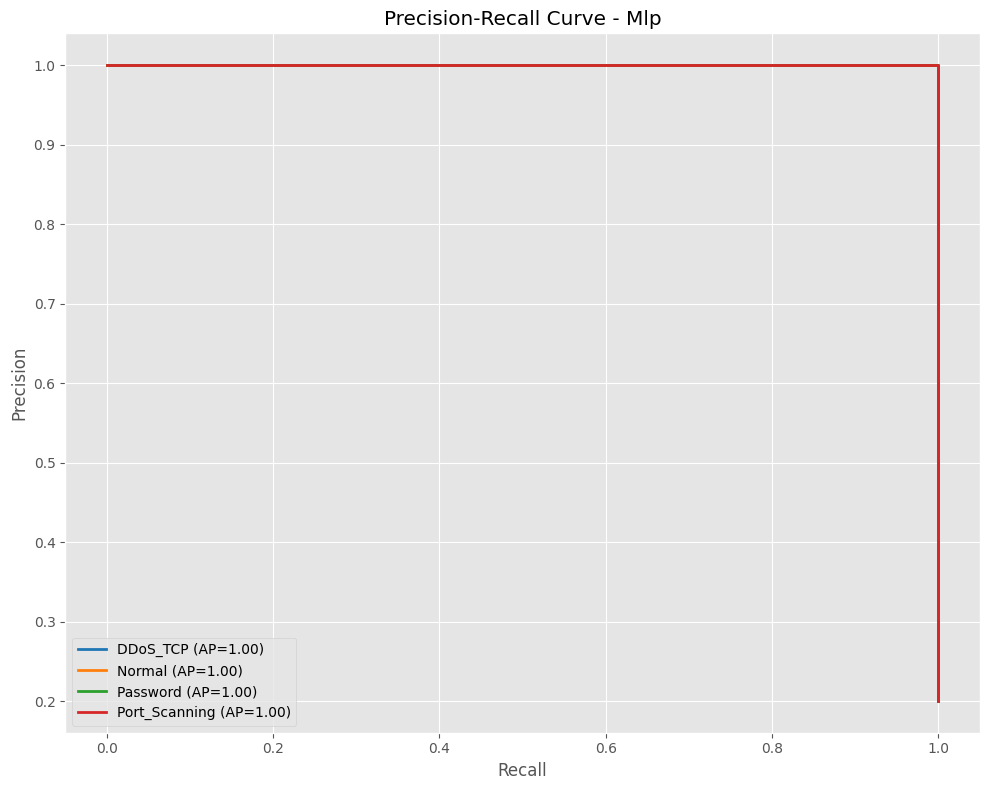

In [39]:
# 🎯 Train + Evaluate Each Model
for name, model in models.items():
    print(f"\n🚀 Training {name.title()}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = round(accuracy * 100, 2)

    print(f"✅ Accuracy: {accuracy_scores[name]:.2f}%")
    report = classification_report(y_test, y_pred, target_names=lb.classes_, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # 📉 Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
    plt.title(f'Confusion Matrix - {name.title()}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f"models/graphs/{name}_conf_matrix.png")
    plt.show()

    # 🔁 PR Curve (if possible)
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test_scaled)
        plt.figure(figsize=(10, 8))
        colors = cycle(plt.cm.tab10.colors)
        for i, color in zip(range(n_classes), colors):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ap = auc(recall, precision)
            plt.plot(recall, precision, lw=2, color=color, label=f'{lb.classes_[i]} (AP={ap:.2f})')

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f'Precision-Recall Curve - {name.title()}')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"models/graphs/{name}_pr_curve.png")
        plt.show()
    else:
        print("Skipping PR Curve (no predict_proba).")

    # 💾 Save Model Files
    joblib.dump(model, f'models/{name}_model.joblib')
    joblib.dump(scaler, f'models/{name}_scaler.joblib')
    joblib.dump(features, f'models/{name}_features.joblib')
    joblib.dump(lb, f'models/{name}_label_binarizer.joblib')

    # 🧾 Collect Summary
    summary_row = {'model': name, 'accuracy': accuracy_scores[name]}
    for cls in lb.classes_:
        summary_row[f'{cls}_precision'] = report[cls]['precision']
        summary_row[f'{cls}_recall'] = report[cls]['recall']
        summary_row[f'{cls}_f1'] = report[cls]['f1-score']
    summary_rows.append(summary_row)

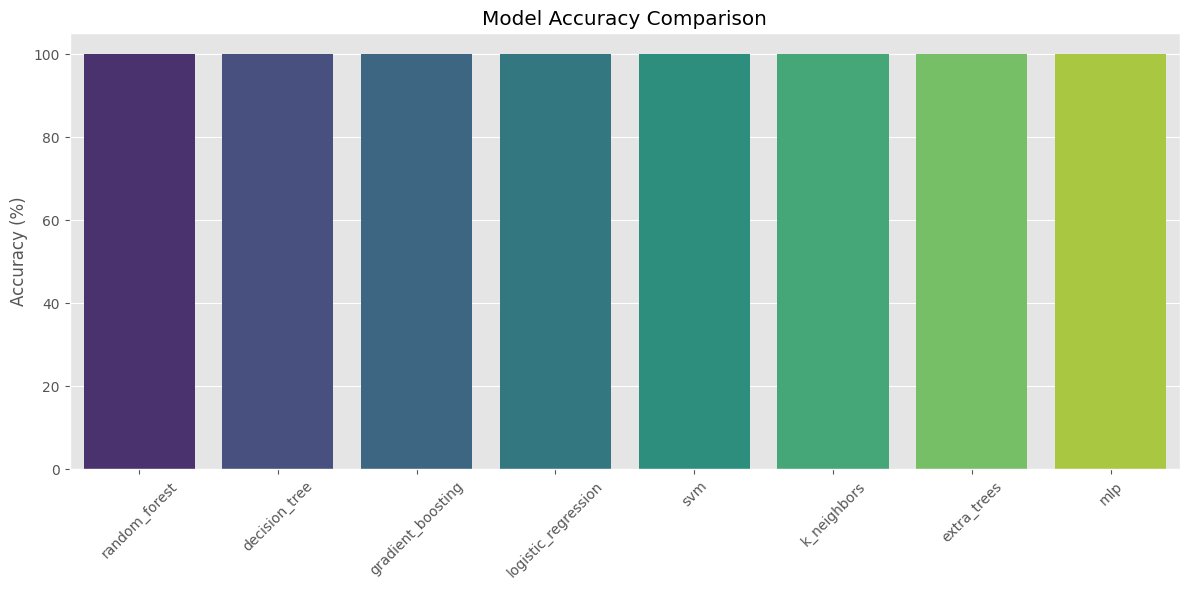

In [40]:
# 📊 Accuracy Comparison Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('models/graphs/accuracy_comparison.png')
plt.show()

In [41]:
#🧾 Save Model Summary Table
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("models/report_summary.csv", index=False)
print("\n📝 Summary report saved as models/report_summary.csv")
print("🎉 All training, evaluation, and visualizations completed successfully!")


📝 Summary report saved as models/report_summary.csv
🎉 All training, evaluation, and visualizations completed successfully!
